In [1]:
import cv2 

img = cv2.imread('../../a/flowers/black_eyed_susan/1007595613_b884ca8509_c.jpg')
""" img = cv2.imread('/home/angel/Desktop/IA/sportimages/basket/basket_0004.jpg') """

print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

256 256 3 3


# Convolutional Neural Networks

# Importar Librerías

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from skimage.transform import resize
from skimage import img_as_ubyte

In [3]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [4]:
dirname = os.path.join(os.getcwd(),'../../dataAugmented/')
""" dirname = os.path.join(os.getcwd(),'/home/likcos/DataSets/sportimages/sportimages') """
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

small_size = (32, 32, 3)  # Adjust the size as needed

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                resized_image = resize(image, small_size)
                resized_image = img_as_ubyte(resized_image)
                images.append(resized_image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if len(image.shape) == 2:
                # Grayscale image - delete the file
                print(f"Deleting: {filepath} - Grayscale image")
                os.remove(filepath)
            # Deleted all non RGB images
            
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  c:\Users\jorge\Desktop\Tec\9no Sem\Tecnm-ITM_IA\CNN\../../dataAugmented/\
c:\Users\jorge\Desktop\Tec\9no Sem\Tecnm-ITM_IA\CNN\../../dataAugmented/\black_eyed_susan 1
c:\Users\jorge\Desktop\Tec\9no Sem\Tecnm-ITM_IA\CNN\../../dataAugmented/\dandelion 14959
c:\Users\jorge\Desktop\Tec\9no Sem\Tecnm-ITM_IA\CNN\../../dataAugmented/\iris 15602
c:\Users\jorge\Desktop\Tec\9no Sem\Tecnm-ITM_IA\CNN\../../dataAugmented/\rose 15637
c:\Users\jorge\Desktop\Tec\9no Sem\Tecnm-ITM_IA\CNN\../../dataAugmented/\tulip 14910
Directorios leidos: 5
Imagenes en cada directorio [14960, 15602, 15637, 14910, 15513]
suma Total de imagenes en subdirs: 76622


# Creamos las etiquetas

In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  76622


In [6]:
flores=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    flores.append(name[len(name)-1])
    indice=indice+1

0 black_eyed_susan
1 dandelion
2 iris
3 rose
4 tulip


In [7]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [8]:
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)
print(len(images))


Shape of X: (76622, 32, 32, 3)
Shape of y: (76622,)
76622


In [9]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61297, 32, 32, 3) (61297,)
Testing data shape :  (15325, 32, 32, 3) (15325,)


Text(0.5, 1.0, 'Ground Truth : 1')

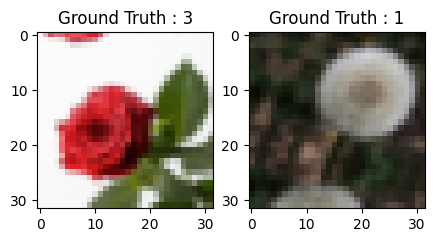

In [10]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

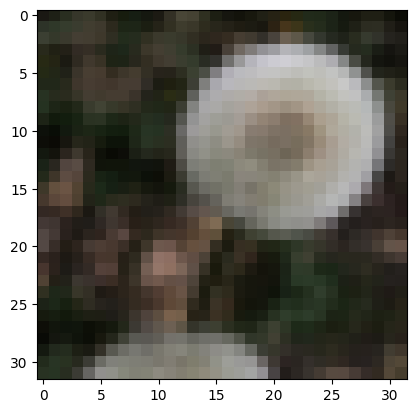

In [11]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [12]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0.]


# Creamos el Set de Entrenamiento y Validación

In [13]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [14]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49037, 32, 32, 3) (12260, 32, 32, 3) (49037, 5) (12260, 5)


# Creamos el modelo de CNN

In [15]:
#declaramos variables con los parámetros de configuración de la red
""" INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001 """
INIT_LR = 0.003 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 200 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 16 # cantidad de imágenes que se toman a la vez en memoria

In [16]:
flor_model = Sequential()
flor_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(32,32,3)))
flor_model.add(LeakyReLU(alpha=0.1))
flor_model.add(MaxPooling2D((2, 2),padding='same'))
flor_model.add(Dropout(0.5))
""" 
flor_model.add(Conv2D(64, kernel_size=(3, 3), activation='linear', padding='same'))
flor_model.add(LeakyReLU(alpha=0.1))
flor_model.add(MaxPooling2D((2, 2), padding='same'))
flor_model.add(Dropout(0.5)) """

flor_model.add(Flatten())
flor_model.add(Dense(32, activation='linear'))
flor_model.add(LeakyReLU(alpha=0.1))
flor_model.add(Dropout(0.5))
flor_model.add(Dense(nClasses, activation='softmax'))

In [17]:
flor_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                        

In [18]:
flor_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [19]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
flor_train = flor_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/200


3065/3065 [==============================] - 9s 3ms/step - loss: 1.0608 - accuracy: 0.5830 - val_loss: 0.7579 - val_accuracy: 0.7263
Epoch 2/200
3065/3065 [==============================] - 8s 3ms/step - loss: 0.8029 - accuracy: 0.7011 - val_loss: 0.6624 - val_accuracy: 0.7564
Epoch 3/200
3065/3065 [==============================] - 8s 3ms/step - loss: 0.7192 - accuracy: 0.7333 - val_loss: 0.5962 - val_accuracy: 0.7778
Epoch 4/200
3065/3065 [==============================] - 8s 3ms/step - loss: 0.6675 - accuracy: 0.7532 - val_loss: 0.5639 - val_accuracy: 0.7919
Epoch 5/200
3065/3065 [==============================] - 8s 3ms/step - loss: 0.6314 - accuracy: 0.7674 - val_loss: 0.5250 - val_accuracy: 0.8082
Epoch 6/200
3065/3065 [==============================] - 8s 3ms/step - loss: 0.6044 - accuracy: 0.7805 - val_loss: 0.5045 - val_accuracy: 0.8147
Epoch 7/200
3065/3065 [==============================] - 8s 3ms/step - loss: 0.5826 - accuracy: 0.7881 - val_loss: 0.4860 - val_

In [20]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
""" flor_model.save("/home/likcos/setDocto/celulas.h5py") """
flor_model.save("./flor_model.h5py")

INFO:tensorflow:Assets written to: ./flor_model.h5py\assets


INFO:tensorflow:Assets written to: ./flor_model.h5py\assets


# Evaluamos la red

In [21]:
test_eval = flor_model.evaluate(test_X, test_Y_one_hot, verbose=1)

479/479 [==============================] - 1s 1ms/step - loss: 0.2893 - accuracy: 0.8947


In [22]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.28932806849479675
Test accuracy: 0.8946818709373474


In [23]:
flor_train.history

{'loss': [1.0607829093933105,
  0.8028667569160461,
  0.7192361354827881,
  0.6675447821617126,
  0.6314215064048767,
  0.6043760776519775,
  0.5825626850128174,
  0.5655426383018494,
  0.5491377711296082,
  0.5402011871337891,
  0.5280810594558716,
  0.5189332365989685,
  0.5129774808883667,
  0.5046629905700684,
  0.49985331296920776,
  0.4942205250263214,
  0.488523006439209,
  0.4839508831501007,
  0.47818467020988464,
  0.4804397523403168,
  0.47467344999313354,
  0.4704866111278534,
  0.4710451066493988,
  0.46464619040489197,
  0.46438631415367126,
  0.4587947428226471,
  0.45273739099502563,
  0.4551866352558136,
  0.4485599398612976,
  0.4465485215187073,
  0.44770169258117676,
  0.4435846209526062,
  0.44324782490730286,
  0.4402995705604553,
  0.4405394494533539,
  0.4379117488861084,
  0.4379238188266754,
  0.43541476130485535,
  0.4317876100540161,
  0.43013566732406616,
  0.42987337708473206,
  0.42868533730506897,
  0.4272651672363281,
  0.42767420411109924,
  0.42500603

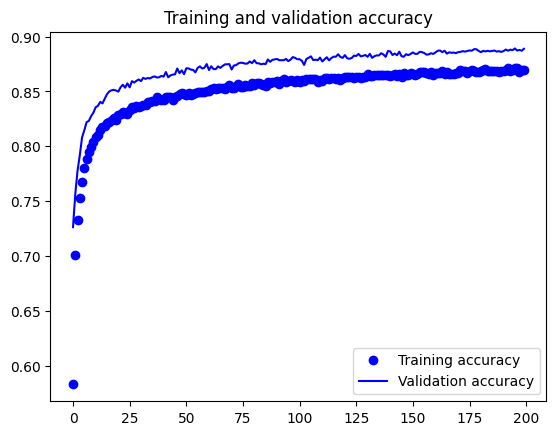

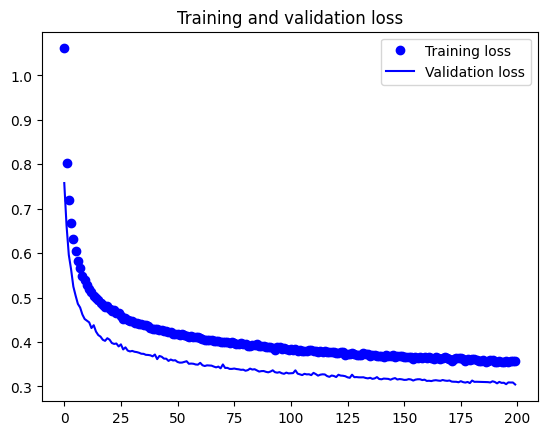

In [24]:
accuracy = flor_train.history['accuracy']
val_accuracy = flor_train.history['val_accuracy']
loss = flor_train.history['loss']
val_loss = flor_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
predicted_classes2 = flor_model.predict(test_X)

479/479 [==============================] - 1s 1ms/step


In [26]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [27]:
predicted_classes.shape, test_Y.shape

((15325,), (15325,))

# Aprendamos de los errores: Qué mejorar

Found 13711 correct labels


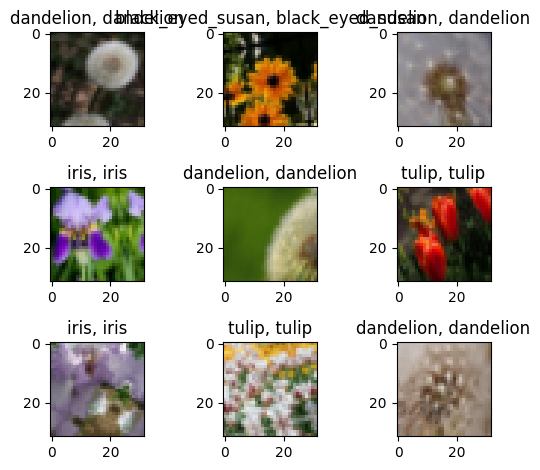

In [28]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(flores[predicted_classes[correct]],
                                                    flores[test_Y[correct]]))

    plt.tight_layout()

Found 1614 incorrect labels


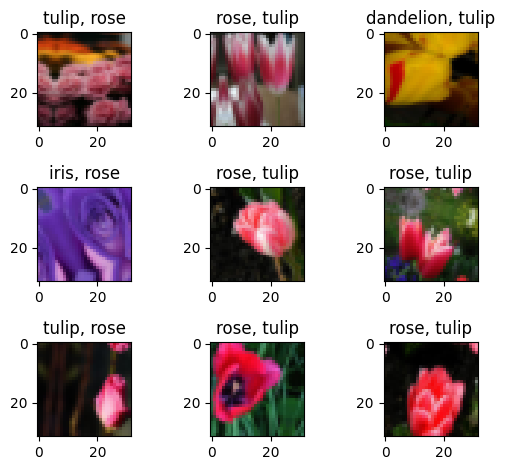

In [29]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(flores[predicted_classes[incorrect]],
                                                    flores[test_Y[incorrect]]))
    plt.tight_layout()

In [30]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.96      0.98      0.97      3041
     Class 1       0.92      0.95      0.93      3136
     Class 2       0.94      0.93      0.93      3145
     Class 3       0.79      0.85      0.82      2940
     Class 4       0.86      0.76      0.81      3063

    accuracy                           0.89     15325
   macro avg       0.89      0.89      0.89     15325
weighted avg       0.89      0.89      0.89     15325

